# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Classifying Chest X-rays by Disease with Neural Networks
## CS109b: Advanced Topics in Data Science



**Harvard University**<br/>
**Spring 2022**<br/>
**Team members**: Alex Lim, Jinjie Liu, Steven Worthington


<hr style="height:2pt">

# Introduction

## i. About This Notebook

This notebook represents a summary of a series of exploratory analysis, wherein we attempt various approaches to classify X-ray images into 14 disease classes and a 'no finding' class.

**For an overview of the analytical sections of this notebook, please see the [Notebook Contents](#Notebook-Contents) index listed below this Introduction.**

### i.i. A note about supporting notebooks

The code and results reported in this notebook are only a summary of the work completed for this project - they represent the final form of our analyses. Supplemental notebooks containing auxillary EDA, data cleaning, and model exploration illustrated in this report can be found in the **`notebooks/`** directory of the **[GitHub project repository](https://github.com/stevenworthington/chestXray)**. The notebooks in that repository are designed to be run in sequential numbered order to reproduce the results shown here. In addition, throughout this report, we will provide links to specific supporting notebooks for further reference.

## ii. Research Questions

After initial exploration and cleaning of the data, we have focused our efforts on the following research questions:

1. Which model architecture performs best for out-of-sample classification of the X-ray images into the 14 disease classes and 'no finding' class?

2. What features in the images and which layers in the model are driving the output classification?

## iii. Summary of Findings

Summarize here.


<a name="Notebook-Contents"></a>
# Notebook Contents

[Introduction](#Introduction)

[Setup](#Setup)

**[1. The Data and EDA](#1.-The-Data-and-EDA)**

- [1.1. The Data](#1.1.-The-Data)

- [1.2. Exploratory Data Analysis](#1.2.-Exploratory-Data-Analysis)

- [1.3. Major Findings](#1.3.-Major-Findings)

**[2. Research Questions](#2.-Research-Questions)**

**[3. Data Preprocessing](#3.-Data-Preprocessing)**

- [3.1. Image Data](#3.1.-Image-Data)

- [3.2. Label Data](#3.2.-Label-Data)

- [3.3 Combined Data](#3.3-Combined-Data)

**[4. Model Training](#4.-Model-Training)**

- [4.1. Callbacks & Loss Functions](#4.1.-Callbacks-&-Loss-Functions)

- [4.2. Model Architecture](#4.2.-Model-Architecture)

- [4.3. Compile & Train](#4.3.-Compile-&-Train)

- [4.4. Model Findings](#4.3.-Model-Findings)

**[5. Model Evaluation](#5.-Model-Evaluation)**

- [5.1. Plot History](#5.1.-Plot-History)

- [5.2. Performance Metrics](#5.2.-Performance-Metrics)

**[6. Layer Visualizations](#6.-Layer-Visualizations)**

**[7. Conclusions](#7.-Conclusions)**

**[8. Future Work](#8.-Future-Work)**

**[9. References](#9.-References)**

# Setup

[Return to top](#Notebook-Contents)

The following sections include general setup code for:
1. Installing the necessary packages needed for data preparation, modeling, and visualization
2. Checking Colab GPU, CPU, and RAM allocations
3. Setting pseudo-random number seeds for reproducibility
4. Mounting Google Drive to Colab

### Install packages

In [ ]:
# Install additional packages

!pip install tf_keras_vis
!pip install -q -U tensorflow_addons

     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
import os
import pathlib
import re
from glob import glob
import random
import time
import zipfile
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import time
from itertools import islice, count
import warnings
warnings.simplefilter('ignore')
plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')

from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Activation, Input, SpatialDropout2D
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization, GaussianNoise, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam, Adamax, Nadam, SGD, Adagrad, RMSprop
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.initializers import he_normal, glorot_normal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score

### Check GPU and CPU instances

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Check which GPU is assigned to the session
!nvidia-smi

Fri May  6 20:46:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    35W / 250W |    377MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Set seeds and mount Google Drive

In [ ]:
# Ensure replicable results
import os
import random as rn
SEED = 109
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to Google Drive
base_path = '/content/drive/My Drive/Colab Notebooks/CSCI_109b/cs109b_final_project/'

Mounted at /content/drive


<a name="1.-The-Data-and-EDA"></a>
# 1. The Data and EDA

[Return to top](#Notebook-Contents)

<a name="1.1.-The-Data"></a>
## 1.1 The Data

**Data Source**

The Chest X-ray dataset consists of 112,120 X-ray images from 32,717 patients. The X-rays have been classified into 14 disease categories (a total of \~27K images) and a 'no finding' category (a total of \~85K images) indicating the absence of evidence for disease. 

**Level of Observation**

The level of observation is images nested within patients - that is, patients often have multiple images in the dataset and these could represent alternate orientations taken at one time point or a series of X-rays recording disease progression over time.

**Data Composition**

Our initial look at the data and files provided revealed the following information:
1. The images are stored in 12 different zipped directories in an online repository. These will need to be downloaded, extracted, and then uploaded to Google Drive for use with Colab and to share amongst the team.
2. Images have already been partitioned into two training/evaluation and testing sets, based on patient ID, with meta-data files indicating which images belong to which set ("train_val_list.txt" and "test_list.txt"). However, separate train and validation sets are not provided and will need to be created, by partitioning the images by patient ID to avoid data leakage.
3. Labels for training images are provided in a "Data_Entry_2017_v2020.csv" file. 
4. There is a small subset (~1K) of relatively class-balanced images referenced in a "BBox_List_2017.csv" file, which may be useful for code prototyping.

<a name="1.2.-Exploratory-Data-Analysis"></a>
## 1.2 Exploratory Data Analysis

### Example X-ray images rescaled to 256x256 pixels

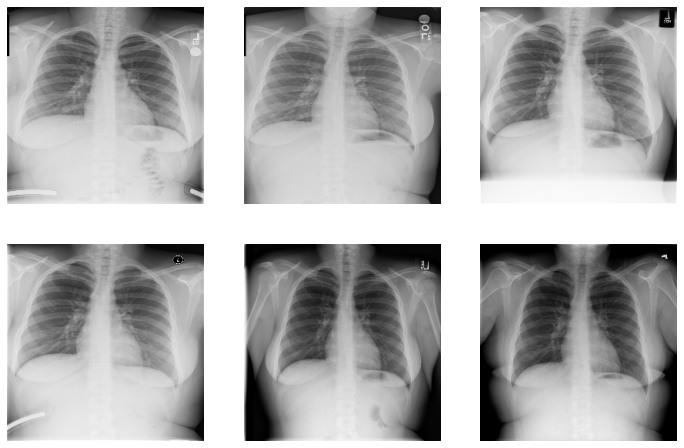

In [ ]:
# Plot small sample of X-ray images

num_imgs = 6
DIR = base_path + 'images_rescaled/images_001/'

combined_xray_images = np.array(
    [imageio.imread(os.path.join(DIR, f"00001335_00{i}.png")) for i in range(num_imgs)]
)

_, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()

for img, ax in zip(combined_xray_images, axes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

**Findings**

Visualizing the downsized X-ray images suggests that the new resolution of 256x256 retains enough detail to be useful for training.

### Data from "Data_Entry_2017_v2020.csv"

In [ ]:
# Load "Data_Entry_2017_v2020.csv"

labels_path = base_path + 'meta_data/Data_Entry_2017_v2020.csv'
data_entry_df = pd.read_csv(labels_path)

# Examine first 5 rows of dataframe
print(f'Shape of data_entry_df: {data_entry_df.shape}')
display(data_entry_df.head())

Shape of data_entry_df: (112120, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


**Findings**

Inspection of the label data in "Data_Entry_2017_v2020.csv" makes clear there are multiple disease labels per image. We will therefore need to split each label string associated with an image using the "|" separator to generate counts of disease occurrence.

### Unique diseases & disease combinations

In [ ]:
# Determine the number of unique label combinations
disease_combinations = data_entry_df['Finding Labels'].unique()
print(f'Number of unique disease combinations: {len(disease_combinations)}\n')

# Split up disease_combinations into individual diseases - get number of unique labels
disease_combinations_split = [combination.split('|') for combination in disease_combinations]
diseases = list(set([disease for observation in disease_combinations_split for disease in observation]))

# Sanity check - how many unique diseases are present in the data
print(f'Number of unique diseases (including No Finding): {len(diseases)}\n')
print('Unique diseases (including No Finding): \n')
for disease in diseases:
  print(disease)

Number of unique disease combinations: 836

Number of unique diseases (including No Finding): 15

Unique diseases (including No Finding): 

Emphysema
No Finding
Pneumonia
Infiltration
Nodule
Edema
Consolidation
Atelectasis
Pneumothorax
Mass
Pleural_Thickening
Effusion
Cardiomegaly
Fibrosis
Hernia


**Findings**

There are a total of 14 unique diseases, plus a 'no finding' class that indicates the absense of evidence for disease being present. There are also 836 different combinations of diseases.

### One-hot encode labels

In [ ]:
# One hot encode label data

# Rename image column
data_entry_df = data_entry_df.rename({'Image Index': 'image_filename'}, axis=1)

# Helper function to create one-hot encoded dataframe
@np.vectorize
def one_hot_disease(label, disease='No Finding'):
  if disease in label:
    return 1
  return 0

# Create one-hot encoded dataframe
one_hot_disease_df = data_entry_df[['image_filename']]
for disease in diseases:
  one_hot_disease_df[disease] = one_hot_disease(data_entry_df['Finding Labels'], disease=disease)

# Rename no finding column
#one_hot_disease_df = one_hot_disease_df.rename({'No Finding': 'No_Finding'}, axis=1)

# Examine first 5 rows of one_hot_disease_df dataframe
print(f'Shape of one_hot_disease_df: {one_hot_disease_df.shape}')
display(one_hot_disease_df.head())

Shape of one_hot_disease_df: (112120, 16)


,image_filename,Emphysema,No Finding,Pneumonia,Infiltration,Nodule,Edema,Consolidation,Atelectasis,Pneumothorax,Mass,Pleural_Thickening,Effusion,Cardiomegaly,Fibrosis,Hernia
0,00000001_000.png,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,00000001_001.png,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,00000001_002.png,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,00000002_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


**Findings**

There are a total of 112,120 unique image filenames in the meta-data.

### Disease occurence

Proportion of healthy patients:
0.538

Proportion of patients with 1 disease:
0.276

Proportion of patients with more than 1 disease:
0.185



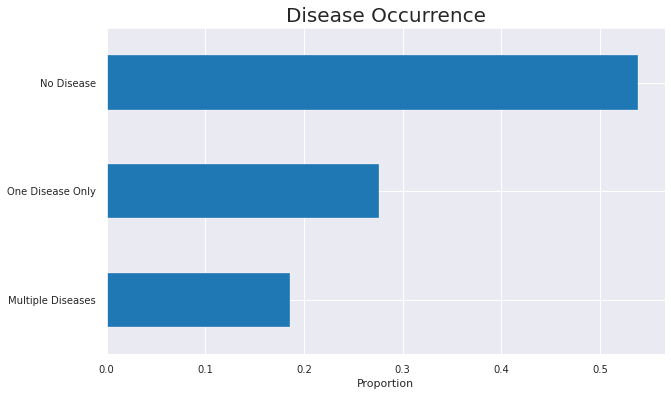

In [ ]:
# Create a copy of the disease list without 'No Finding'
diseases14 = diseases.copy()
diseases14.remove('No Finding')

# Create pd.Series corresponding to the number of observed diseases for a given patient
n_diseases = one_hot_disease_df[diseases14].sum(axis=1)

# How many patients are healthy (no diseases)?
no_disease_prop = (n_diseases == 0).mean()
print('Proportion of healthy patients:')
print(f"{no_disease_prop:.3f}\n")

# How many patients have just one disease?
one_disease_prop = (n_diseases == 1).mean()
print('Proportion of patients with 1 disease:')
print(f"{one_disease_prop:.3f}\n")

# How many patients have multiple diseases?
multi_disease_prop = (n_diseases > 1).mean()
print('Proportion of patients with more than 1 disease:')
print(f"{multi_disease_prop:.3f}\n")

# Visualize the above results
inds = ['No Disease', 'One Disease Only', 'Multiple Diseases']
props = pd.Series(
    data = [no_disease_prop, one_disease_prop, multi_disease_prop],
    index = inds
)

fig, ax = plt.subplots(figsize=(10, 6))

props[::-1].plot(kind = 'barh', ax = ax)

ax.set_xlabel('Proportion')
ax.set_title('Disease Occurrence', fontsize=20);

**Findings**

The majority of patients (\~54%) have no evidence of disease, while \~28% have been diagnosed with a single disease, and \~19% have been diagnosed with multiple diseases.

### Disease distribution

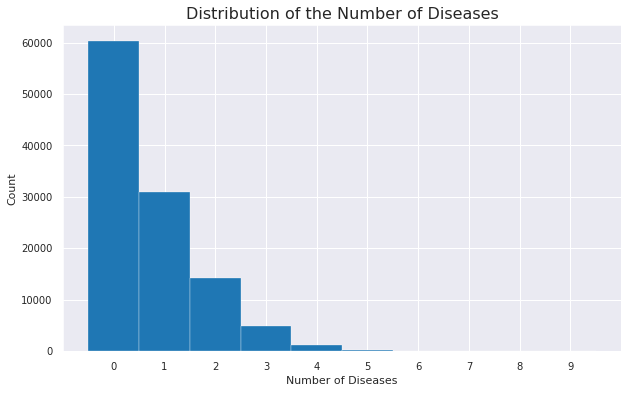

In [ ]:
# What is the distribution of n_diseases?
fig, ax = plt.subplots(figsize=(10, 6))

bins = np.arange(0, max(n_diseases.values) + 1.5) - 0.5

ax.hist(n_diseases, bins = bins)

ax.set_xticks([i for i in range(0, max(n_diseases) + 1)])
ax.set_xlabel('Number of Diseases')
ax.set_ylabel('Count')
ax.set_title('Distribution of the Number of Diseases', fontsize=16);

**Findings**

While the majority of X-ray images show either no disease finding (\~60K) or a single disease (\~30K), there is a long right tail to the distribution. Some images have as many as 9 out of the possible 14 disease labels.


### Commonly occurring diseases

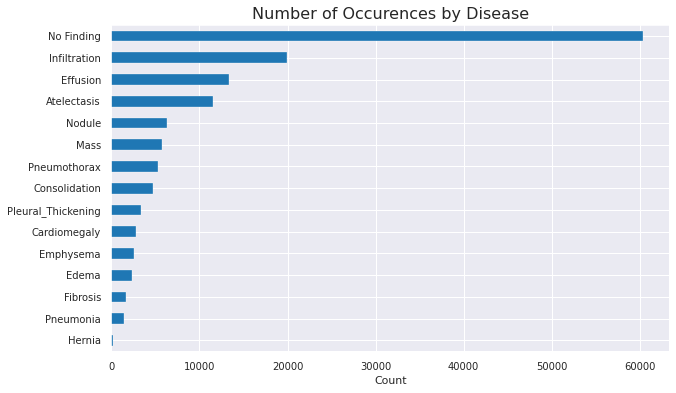

In [ ]:
# What's the most commonly occuring disease?
disease_counts = one_hot_disease_df[diseases].sum(axis = 0).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(10, 6))

disease_counts[::-1].plot(kind = 'barh', ax = ax)

ax.set_xlabel('Count')
ax.set_title('Number of Occurences by Disease', fontsize = 16);

**Findings**

Occurence differs dramatically among different diseases. Several diseases (e.g., hernia, pneumonia, fibrosis) have only a few hundred occurences in the X-ray images, while others (e.g., infiltration, effusion, atelectasis) have over 10,000 occurences. This means that the data exhibit extreme class imbalance.

### Disease correlations (co-morbidity)

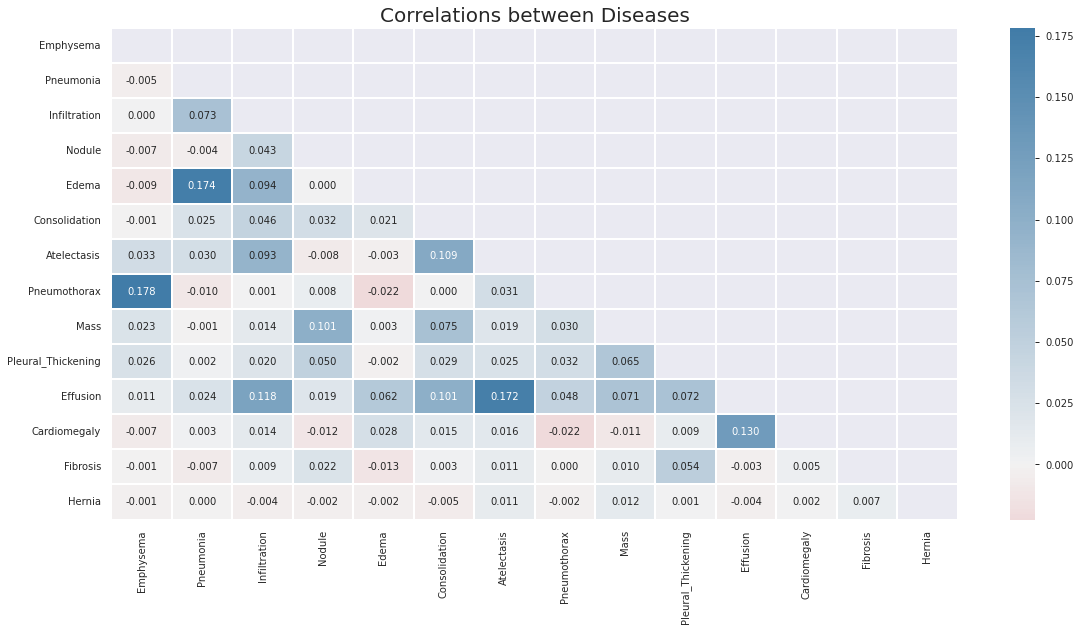

In [ ]:
# Plot heatmap of correlation matrix
corr_mat = one_hot_disease_df[diseases14].corr()
bool_mask = np.triu(np.ones_like(corr_mat, dtype=bool))
cmap = sns.diverging_palette(h_neg = 10,
                             h_pos = 240,
                             as_cmap = True)

fig, ax = plt.subplots(figsize=(16, 8))

fig.tight_layout(pad = 3)

sns.heatmap(corr_mat, mask = bool_mask,
            center = 0, cmap = cmap, linewidths = 1,
            annot = True, fmt = '.3f', ax = ax)

ax.set_title('Correlations between Diseases', fontsize=20);

**Findings**

Most diseases had some degree of correlation with one another, indicating co-morbidity, though the magnitude of correlation is quite low. The highest correlations occur between 'pneumothorax' and 'emphysema' (r=0.178), between 'pneumonia' and 'edema' (r=0.174), and between 'effusion' and 'atelectasis' (r=0.172).


<a name="1.3.-Major-Findings"></a>
## 1.3 Summary of Major EDA Findings

After exploring the image data and the disease class labels, we have identified 5 major issues that will need to be addressed during data pre-processing and analysis.

1. The size of the dataset is computationally challenging. In particular:
  - Images are large (1024 x 1024 pixels). We will address this problem by downscaling the images to 256 x 256 pixels using pixel area relation interpolation.
  - Images are abundant (\~109K). We will address this problem by downsampling some of the more abundant image classes (esp. the 'no finding' class).
  - We will also implement an analysis pipeline built upon the TF dataset API, so as the maximize computational efficiency.

2. Patients sometimes have multiple diseases (i.e., images can have multiple labels). We will address this problem by one-hot encoding class labels and using an element-wise sigmoid activation for our model's output layer, so that we get a 0 or 1 prediction of whether an image displays evidence of a given disease or not, rather than a probability for each class (as with softmax activation). This will simultaneously address the issue that disease occurrence is correlated.

3. The 15 image categories exhibit extreme class imbalance. We have decided to address this problem by using a mix of approaches:
  - Downsampling for diseases with lots of images.
  - A weighted loss function.
  - Evaluation metrics that are unaffected by class imbalance (e.g., AUROC).

4. Data leakage due to repeated X-rays for each patient. We will need to create data partitions for training, validation, and testing sets at the patient level, rather than the image level, otherwise images from a single patient may be present in several data sets. Given the fact that we would expect X-rays from the same person to be highly similar, this in effect would be a form of data leakage that may result in artificially inflated performance metrics and reduced generalizability. While we have been provided with patient ID partitioned training/validation and test sets, we will still need to separate the training and validation sets at the patient level.

5. Incorporating non-image data into the model. Non-image data (e.g., sex, age, patient ID) may also be highly predictive of disease class. We will explore model architectures that can incorporate both image and non-image data by building custom model layers.

<a name="2.-Research-Questions"></a>
# 2. Research Questions

[Return to top](#Notebook-Contents)

After initial exploration and cleaning of the data, we have focused our efforts on the following research questions:

1. Which model architecture performs best for out-of-sample classification of the X-ray images into the 14 disease classes and 'no finding' class?

2. What features in the images and which layers in the model are driving the output classification?

<a name="3.-Data-Preprocessing"></a>
# 3. Data Preprocessing

[Return to top](#Notebook-Contents)

Throughout data preprocessing, our stategy is to use a TF dataset pipeline to maximize computational efficieny by taking advantage of data prefetching. We never import images using numpy, but rather import and perform all preprocessing and data augmentation using the TF dataset API. We have organized our data preprocessing steps into those related to image data, label data, and the combination of both. We employ the following steps:

1. Image data:
  - Partition image filenames in sets by patient ID. We retain the existing test set split, but create a new partition of train and validation sets by patient ID (70% train, 30% validation).
  - Downsample images that have high occurrence. We disproportionately downsample images with high occurrence. It should be noted that, due to the multi-label nature of the images, we could not downsample all disease classes to the same number of observations and thus eliminate class imbalance (since including an observation from one class will often lead to automatically including observations from other classes). However, we sought to make the data more balanced and also reduce the computational burden of modeling by not training the models on a huge number of images.
  - Load images into TF datasets.
2. Label data:
  - Labels were already one-hot encoded for the EDA.
  - Partition one-hot encoded labels into the same sets as images, using image filenames as an index.
  - Load one-hot encoded labels into TF datasets.
3. Combined data:
  - Zip together images and labels into combined TF datasets.
  - Set up batching and prefetching for all TF datasets. We used fairly small batch sizes (64 for train set, 32 for validation and test sets) to reduce the memory burden and allow us to train more complex models on larger samples. We used autotune to maximize efficiency of prefetching data.

We reserve data augmentation for a later stage, since we decided to implement this within layers of the model so as to reduce computation time by using GPU cycles rather than the CPU.

<a name="3.1.-Image-Data"></a>
## 3.1 Image Data

### Partition image filenames into sets by patient ID

Here we split the existing combined train/validation set of image labels by patient ID into two new sets (70% train, 30% validation). The existing test set of labels, already split by patient ID, is retained.

In [ ]:
# Load "train_val_list.txt"

splits_path_train_val = base_path + 'meta_data/train_val_list.txt'
splits_train_val_df = pd.read_csv(splits_path_train_val, header=None, names=['image_names'])

# Examine first 5 rows of dataframe
print(f'Shape of splits_train_val_df: {splits_train_val_df.shape}')
display(splits_train_val_df.head())

Shape of splits_train_val_df: (86524, 1)


,image_names
0,00000001_000.png
1,00000001_001.png
2,00000001_002.png
3,00000002_000.png
4,00000004_000.png


In [ ]:
# Create patient ID column
splits_train_val_df['patient_ID'] = splits_train_val_df['image_names'].apply(lambda x: re.sub('([_].*)', '', x))

# Get number of patients in train and validation sets
n_patients = len(set(splits_train_val_df['patient_ID']))
print('Number of train and validation patients:', n_patients)

Number of train and validation patients: 28008


In [ ]:
# Set the number of patients in the train and validations sets

# Use a probability of 0.7 for inclusion in training set
train_prob = 0.7

# Calculate how many patients are in each set
n_train_patients = int(np.floor(n_patients * train_prob))
n_val_patients = n_patients - n_train_patients

print('Number of train set patients:', n_train_patients)
print('Number of validation set patients:', n_val_patients)

Number of train set patients: 19605
Number of validation set patients: 8403


In [ ]:
# Get image names in train and validations sets

# Group data frame by patient ID
gb = splits_train_val_df.groupby('patient_ID')

# Get list of train and validation set unique patient IDs
train_val_patient_IDs = list(gb.groups.keys())

# Get random sample of indices for training and validation set patient IDs
random.seed(109)
train_patients_idx = random.sample(range(n_patients), k=n_train_patients)
val_patients_idx = list(set(range(n_patients)).difference(set(train_patients_idx)))
val_patients_idx = [int(i) for i in val_patients_idx]

# Get lists of train and validation set patient IDs corresponding to the above indices
train_IDs = [train_val_patient_IDs[i] for i in train_patients_idx]
val_IDs = [train_val_patient_IDs[i] for i in val_patients_idx]
print("Training set ID size sanity check:", len(train_IDs))
print("Validation set ID size sanity check:", len(val_IDs))

# Get train and validation set image names partitioned by patient IDs
train_image_names = splits_train_val_df.loc[splits_train_val_df['patient_ID'].isin(train_IDs), 'image_names'].tolist()
val_image_names = splits_train_val_df.loc[splits_train_val_df['patient_ID'].isin(val_IDs), 'image_names'].tolist()
print('Number of train set images:', len(train_image_names))
print('Number of validation set images:', len(val_image_names))

Training set ID size sanity check: 19605
Validation set ID size sanity check: 8403
Number of train set images: 60913
Number of validation set images: 25611


In [ ]:
# Load "test_list.txt"

splits_path_test = base_path + 'meta_data/test_list.txt'
splits_test_df = pd.read_csv(splits_path_test, header=None, names=['image_names'])
test_image_names = splits_test_df['image_names'].tolist()

print('Number of test set images:', len(test_image_names))

Number of test set images: 25596


### Image downsampling

Here we set up some functions to downsample disease classes that have high occurrence. Since the images often have multiple labels, we cannot eliminate class imbalance by downsampling, since removing or including an observation for one class often directly impacts the inclusion of an obseration for another class. But, we can make the data more balanced and also reduce the computational burden by not training the models on a huge number of images from just 2-3 classes.

The downsampling is performed by randomly selecting a subsample of N images from a given disease class from the population of images within the given dataset (train, validation, and test).

Downsampling allowed us to quickly explore different model architectures on a modestly sized set of training images (typically 2-3K) and then easily scale the analysis up to use a larger sample for the final models. Our final model was trained on 29555 images, with 10954 images in the validation set, and 14445 images in the test set (a total of 54954 images altogether).

In [ ]:
# KEEP = number to downsample each image class to (if disease occurence were independent)

KEEP_TOTAL = 10000 
KEEP_TRAIN = int(0.6 * KEEP_TOTAL) 
KEEP_VAL = int(0.2 * KEEP_TOTAL) 
KEEP_TEST = int(0.2 * KEEP_TOTAL) 

# 800 = 480 (5607), 160 (1867), 160 (1766) # 35 mins for training
# 600 = 360 (4194), 120 (1416), 120 (1342) # 25 mins for training
# 400 = 240 (2831), 80 (947), 80 (912) # 15 mins for training
# 200 = 120 (1452), 40 (495), 40 (451) # 8 mins for training

In [ ]:
# Function to downsample images filenames using random sample

def downsample_image_filenames(df, keep):
  """
  keep = number to downsample each image class to (if disease occurence were independent)
  Returns a list of terminal image filesnames without base path
  """
  # Downsample each series of disease filenames
  downsampled_disease_filenames = []
  for disease in diseases:
    complete_disease_filenames = df['image_filename'][df[disease] == 1]
    try:
      downsampled_disease_filenames.append(complete_disease_filenames.sample(keep, random_state=109))
    except ValueError:
      downsampled_disease_filenames.append(complete_disease_filenames)
  # Flatten list
  downsampled_list_flat = flatten_list(downsampled_disease_filenames)     
  # Get unique set of downsampled filenames
  filenames_to_keep = list(set(downsampled_list_flat))
  return filenames_to_keep

In [ ]:
# Function to flatten lists of lists

def flatten_list(L):
    return [item for sublist in L for item in sublist]

In [ ]:
# Function to get image filenames

def get_filenames(path, subdir):
  """
  Returns a list of full paths to image filesnames
  """
  # Path to images
  images_path = path + subdir
  # Filenames with full absolute paths
  images_filenames_full_path = glob(images_path + '/*')
  # Sort to establish consistent order
  images_filenames_full_path.sort()
  # Get terminal filenames from full path
  # images_filenames = [re.sub('^(.*[/])', '', x) for x in images_filenames_full_path]

  return images_filenames_full_path

In [ ]:
# Train original label class frequencies

train_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(train_image_names)]
print(f"Train labels class frequencies: \n{train_labels_df.drop(columns='image_filename').sum(axis=0)}")

Train labels class frequencies: 
Emphysema               925
No Finding            35324
Pneumonia               635
Infiltration           9835
Nodule                 3382
Edema                   997
Consolidation          2040
Atelectasis            5856
Pneumothorax           1872
Mass                   2919
Pleural_Thickening     1633
Effusion               6208
Cardiomegaly           1203
Fibrosis                892
Hernia                   97
dtype: int64


In [ ]:
# Train downsampled label class frequencies

# Downsample image filenames
train_downsampled_image_names = downsample_image_filenames(df=train_labels_df, keep=KEEP_TRAIN)
print(f"Number of downsampled train images: {len(train_downsampled_image_names)}\n")

# Get downsampled labels
train_downsampled_labels_df = train_labels_df[train_labels_df['image_filename'].isin(train_downsampled_image_names)]
print(f"Train downsampled labels class frequencies: \n{train_downsampled_labels_df.drop(columns='image_filename').sum(axis=0)}")

Number of downsampled train images: 29555

Train downsampled labels class frequencies: 
Emphysema              925
No Finding            6000
Pneumonia              635
Infiltration          7865
Nodule                3382
Edema                  997
Consolidation         2040
Atelectasis           5856
Pneumothorax          1872
Mass                  2919
Pleural_Thickening    1633
Effusion              6137
Cardiomegaly          1203
Fibrosis               892
Hernia                  97
dtype: int64


In [ ]:
# Validation original label class frequencies

val_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(val_image_names)]
print(f"Validation labels class frequencies: \n{val_labels_df.drop(columns='image_filename').sum(axis=0)}")

Validation labels class frequencies: 
Emphysema               498
No Finding            15176
Pneumonia               241
Infiltration           3947
Nodule                 1326
Edema                   381
Consolidation           812
Atelectasis            2424
Pneumothorax            765
Mass                   1115
Pleural_Thickening      609
Effusion               2451
Cardiomegaly            504
Fibrosis                359
Hernia                   44
dtype: int64


In [ ]:
# Validation downsampled label class frequencies

# Downsample image filenames
val_downsampled_image_names = downsample_image_filenames(df=val_labels_df, keep=KEEP_VAL)
print(f"Number of downsampled validation images: {len(val_downsampled_image_names)}\n")

# Get downsampled labels
val_downsampled_labels_df = val_labels_df[val_labels_df['image_filename'].isin(val_downsampled_image_names)]
print(f"Validation downsampled labels class frequencies: \n{val_downsampled_labels_df.drop(columns='image_filename').sum(axis=0)}")

Number of downsampled validation images: 10954

Validation downsampled labels class frequencies: 
Emphysema              498
No Finding            2000
Pneumonia              241
Infiltration          2810
Nodule                1326
Edema                  381
Consolidation          812
Atelectasis           2204
Pneumothorax           765
Mass                  1115
Pleural_Thickening     609
Effusion              2257
Cardiomegaly           504
Fibrosis               359
Hernia                  44
dtype: int64


In [ ]:
# Test original label class frequencies

test_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(test_image_names)]
print(f"Test labels class frequencies: \n{test_labels_df.drop(columns='image_filename').sum(axis=0)}")

Test labels class frequencies: 
Emphysema             1093
No Finding            9861
Pneumonia              555
Infiltration          6112
Nodule                1623
Edema                  925
Consolidation         1815
Atelectasis           3279
Pneumothorax          2665
Mass                  1748
Pleural_Thickening    1143
Effusion              4658
Cardiomegaly          1069
Fibrosis               435
Hernia                  86
dtype: int64


In [ ]:
# Train downsampled label class frequencies

# Downsample image filenames
test_downsampled_image_names = downsample_image_filenames(df=test_labels_df, keep=KEEP_TEST)
print(f"Number of downsampled test images: {len(test_downsampled_image_names)}\n")

# Get downsampled labels
test_downsampled_labels_df = test_labels_df[test_labels_df['image_filename'].isin(test_downsampled_image_names)]
print(f"Test downsampled labels class frequencies: \n{test_downsampled_labels_df.drop(columns='image_filename').sum(axis=0)}")

Number of downsampled test images: 14445

Test downsampled labels class frequencies: 
Emphysema             1093
No Finding            2000
Pneumonia              555
Infiltration          4161
Nodule                1623
Edema                  925
Consolidation         1815
Atelectasis           2737
Pneumothorax          2320
Mass                  1748
Pleural_Thickening    1143
Effusion              3601
Cardiomegaly          1069
Fibrosis               435
Hernia                  86
dtype: int64


In [ ]:
# Get full path to filenames of all images across 12 subdirectories

# Get subdirectory names
images_subdir_list = [re.sub('^(.*[/])', '', x) for x in glob(base_path+'images_rescaled/' + '/*')]

# Get full path to filenames across all subdirectories
image_fullpath_filenames_list = [get_filenames(path=base_path+'images_rescaled/', subdir=x) for x in images_subdir_list]
image_fullpath_filenames_list_flat = flatten_list(image_fullpath_filenames_list)

print('Total number of images across 12 subdirectries:', len(image_fullpath_filenames_list_flat))

Total number of images across 12 subdirectries: 112153


In [ ]:
# Get full paths of selected images for train, validation, and test sets

train_selected_images_fullpath = [j for i in train_downsampled_image_names for j in image_fullpath_filenames_list_flat if i in j]
val_selected_images_fullpath = [j for i in val_downsampled_image_names for j in image_fullpath_filenames_list_flat if i in j]
test_selected_images_fullpath = [j for i in test_downsampled_image_names for j in image_fullpath_filenames_list_flat if i in j]

print('Number of train image full paths:', len(train_selected_images_fullpath))
print('Number of validation image full paths:', len(val_selected_images_fullpath))
print('Number of test image full paths:', len(test_selected_images_fullpath))

Number of train image full paths: 29555
Number of validation image full paths: 10954
Number of test image full paths: 14445


### Load images into TF datasets

Here we load the images from the train, validation, and test sets into 3 separate TF datasets.

In [ ]:
# Function to load the image data into TF datasets

def make_tf_image_dataset(filenames, image_size):

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

  filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
  images_ds = filenames_ds.map(parse_image, num_parallel_calls=AUTOTUNE)

  return images_ds

In [ ]:
# Load the image and label data into TF datasets

# NOTE: this will load the grayscale image repeated 3 times (i.e., 3 channels)

IMG_SIZE = 256

# Create image datasets
train_images_ds = make_tf_image_dataset(filenames=train_selected_images_fullpath, image_size=IMG_SIZE)
val_images_ds = make_tf_image_dataset(filenames=val_selected_images_fullpath, image_size=IMG_SIZE)
test_images_ds = make_tf_image_dataset(filenames=test_selected_images_fullpath, image_size=IMG_SIZE)

print("train_images_ds shape: ", train_images_ds)
print("number of training images parsed: ", train_images_ds.cardinality().numpy())
print("val_images_ds shape: ", val_images_ds)
print("number of validation images parsed: ", val_images_ds.cardinality().numpy())
print("test_images_ds shape: ", test_images_ds)
print("number of testing images parsed: ", test_images_ds.cardinality().numpy())

train_images_ds shape:  <ParallelMapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>
number of training images parsed:  29555
val_images_ds shape:  <ParallelMapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>
number of validation images parsed:  10954
test_images_ds shape:  <ParallelMapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>
number of testing images parsed:  14445


<a name="3.2.-Label-Data"></a>
## 3.2 Label Data

### Select one-hot encoded labels for train, validation, and test sets

Here we subset the one-hot encoded labels into the same train, validation, and test sets as the images, using the image filenames as an index.

In [ ]:
# Partition one_hot_disease_df into training, validation, and test set labels

# Reorder labels to match image order
one_hot_disease_df = one_hot_disease_df.sort_values('image_filename') 

# Get terminal filenames without full path
train_selected_images = [re.sub('^(.*[/])', '', x) for x in train_selected_images_fullpath]
val_selected_images = [re.sub('^(.*[/])', '', x) for x in val_selected_images_fullpath]
test_selected_images = [re.sub('^(.*[/])', '', x) for x in test_selected_images_fullpath]

# Logically index one_hot_disease_df based on train, validation, and test set filenames
train_selected_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(train_selected_images)]
val_selected_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(val_selected_images)]
test_selected_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(test_selected_images)]

print('Number of training labels:', train_selected_labels_df.shape)
print('Number of validation labels:', val_selected_labels_df.shape)
print('Number of test labels:', test_selected_labels_df.shape)

Number of training labels: (29555, 16)
Number of validation labels: (10954, 16)
Number of test labels: (14445, 16)


### Load one-hot encoded labels into TF datasets

Here we load the partitioned one-hot encoded label data into 3 TF datasets.

In [ ]:
# Convert lists of one-hot encoded labels to TF datasets

# Create label datasets (remove column of image filenames first)
train_labels_ds = tf.data.Dataset.from_tensor_slices(train_selected_labels_df.drop(columns='image_filename'))
val_labels_ds = tf.data.Dataset.from_tensor_slices(val_selected_labels_df.drop(columns='image_filename'))
test_labels_ds = tf.data.Dataset.from_tensor_slices(test_selected_labels_df.drop(columns='image_filename'))  

print("train_labels_ds shape: ", train_labels_ds)
print("number of training labels parsed: ", train_labels_ds.cardinality().numpy())
print("val_labels_ds shape: ", val_labels_ds)
print("number of validation labels parsed: ", val_labels_ds.cardinality().numpy())
print("test_labels_ds shape: ", test_labels_ds)
print("number of testing labels parsed: ", test_labels_ds.cardinality().numpy())

train_labels_ds shape:  <TensorSliceDataset element_spec=TensorSpec(shape=(15,), dtype=tf.int64, name=None)>
number of training labels parsed:  29555
val_labels_ds shape:  <TensorSliceDataset element_spec=TensorSpec(shape=(15,), dtype=tf.int64, name=None)>
number of validation labels parsed:  10954
test_labels_ds shape:  <TensorSliceDataset element_spec=TensorSpec(shape=(15,), dtype=tf.int64, name=None)>
number of testing labels parsed:  14445


<a name="3.3.-Combined-Data"></a>
## 3.3 Combined Data

### Combine images and labels

Here we combine the image and label TF datasets, by zipping them together to form 3 new TF datasets with both image and label information.

In [ ]:
# Zip together the image and label data into a combined TF datasets

train_ds = tf.data.Dataset.zip((train_images_ds, train_labels_ds))
val_ds = tf.data.Dataset.zip((val_images_ds, val_labels_ds))
test_ds = tf.data.Dataset.zip((test_images_ds, test_labels_ds))

print("Train set shape: ", train_ds)
print("Validation set shape: ", val_ds)
print("Test set shape: ", test_ds)
print("number of training images/labels: ", train_ds.cardinality().numpy())
print("number of validation images/labels: ", val_ds.cardinality().numpy())
print("number of testing images/labels: ", test_ds.cardinality().numpy())

Train set shape:  <ZipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.int64, name=None))>
Validation set shape:  <ZipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.int64, name=None))>
Test set shape:  <ZipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.int64, name=None))>
number of training images/labels:  29555
number of validation images/labels:  10954
number of testing images/labels:  14445


### Batching & prefetching

Here we set up the batched TF datasets with prefetching that is autotuned. We used fairly small batch sizes to reduce memory demands and allow us to train more complex models with a larger sample of data. We shuffled the data for the training set to prevent the model from learning image order information, but not the validation or test sets. 

In [ ]:
# Set up batches

BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VAL = 32
BATCH_SIZE_TEST = 32

train_ds_batches = train_ds.shuffle(buffer_size=40000).batch(BATCH_SIZE_TRAIN).prefetch(buffer_size=AUTOTUNE)
val_ds_batches = val_ds.batch(BATCH_SIZE_VAL).prefetch(buffer_size=AUTOTUNE)
test_ds_batches = test_ds.batch(BATCH_SIZE_TEST).prefetch(buffer_size=AUTOTUNE)

print("Train shape: ", train_ds_batches)
print("Validation shape: ", val_ds_batches)
print("Test shape: ", test_ds_batches)

Train shape:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.int64, name=None))>
Validation shape:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.int64, name=None))>
Test shape:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.int64, name=None))>


<a name="4.-Model-Training"></a>
# 4. Model Training

[Return to top](#Notebook-Contents)

**Modeling Strategy**

Our overall modeling strategy was to start by using transfer learning with a base model pretrained on the 'ImageNet' dataset with weights frozen and dense layers excluded. We then built out the top of the model architecture with additional convolutional layers to extract features specifically from the X-ray images and several dense layers, followed by a 15 node (one for each class) output layer with sigmoid activation. 

**Model Architectures**

We tried many different pretrained base models (including `ResNet50`, `EfficientNetB0`, `EfficientNetV2M`, `Xception`, `VGG16`, `VGG19`, `DenseNet121`, `DenseNet201`, `InceptionV3` and others). On top of this foundation, we tried different combinations of additional convolutional layers (typically one or two paired `Conv2D` layers) with various numbers of filters (between 256 to 1024), dense layers with various numbers of nodes (typically one to three layers with a descending number of nodes from 512 or 256 to 128 or 64). We used a `GlobalMaxPooling2D` layer, rather than a `Flatten` layer, to flatten the output of the convolutional part of the model for use in the dense layers, as the former reduced the number of trainable parameters by about half compared with the latter, making training much more efficient. We created a flexible model building function to make the process of exploring different model architectures easier.

**Model Hyperparameters**

We tried different combinations of model hyperparameters. In particular, we implemented different optimizers (`Adam`, `Nadam`, `Adamax`, `SGD`) with many different learning rates (including cyclical learning rates that alternate between fast and slow rates to try and bounce out of local optima), plus other optimization related techniques (e.g., optimizers that included momentum).

**Loss Functions**

We started by using a binary cross-entropy loss function for our 15 node dense output layer with sigmoid activation – this allowed us to get a list of 15 independent probabilities (one for each class) for every image in the validation and test sets. From this, using a 0.5 threshold, we could convert the probabilities into predicted class one-hot encoded labels and then compare these with our ground truth labels to generate performance metrics. Later, we also tried using a weighted loss function to better account for the remaining class imbalance in the training data after image downsampling.

**Regularization**

Once we found a model architecture that produced reasonable performance, we regularized the model parameters. We used dropout layers with various fractions of dropout, as well as L1/L2 regularization for the kernel, bias, and activity, and we tried Gaussian noise and batch normalization methods. In addition, we used data augmentation, including small amounts of `RandomRotation`, `RandomZoom`, and `RandomTranslation`, but not `RandomFlipping` because this would potentially produce training images with anatomically misplaced structures (e.g., the heart on the right side). We performed data augmentation as layers within the model itself, so as to take advantage of the parallelization capabilities of the GPU, rather than running these steps during preprocessing on the CPU.

**Callbacks**

We included several callbacks to improve model training. We used early stopping with a patience of 10 epochs and weights from the best training epoch retained. We used the reduce learning rate on plateau callback to slow the learning rate if performance in the validation set had not improved within 5 epochs. We also used a learning rate scheduler to decrease learning rates expoentially after the first 7 epochs. Finally, we used cyclical learning rates with a minimum of 1e-8 and maximum of 1e-2 to try and bounce out of local optima.

**Metrics**

For training, we used the `AUROC` metric to evaluate model performance on the validation set. We choose `AUROC` because it is insensitive to changes in class distribution. Once we had models that performed reasonably well, we then generated other metrics (e.g., F-1 score, precision-recall curve) on the test set. 

<a name="4.1.-Callbacks-&-Loss-Functions"></a>
## 4.1 Callbacks & Loss Functions

Here we define several callbacks to help with training. We also define a weighted loss function.

In [ ]:
# Callbacks

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min', 
    min_delta=0.5, 
    patience=10, 
    restore_best_weights=True, 
    verbose=True)

# Reduce learning rate by factor of 0.2 if val_loss does not improve within 5 epochs
reduce_lrt_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    mode='min',
    min_delta=0.2,
    factor=0.2,
    patience=5, 
    min_lr=1e-6,
    verbose=2)

# This function keeps the initial learning rate for the first 7 epochs and decreases it exponentially after that
def scheduler(epoch, lr):
    if epoch <= 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lrt_scheduler = LearningRateScheduler(scheduler)

# Save model history
csv_logger = CSVLogger(base_path + 'output/training_history.log', separator=',', append=False)

In [ ]:
# Weighted loss function

# Get class frequencies - used to get pos_weights, neg_weights for Weighted loss function
def get_class_frequencies(y_cols):
  """
  Returns positive and negative frequencies for each class.

  Args:
    y_cols (np.array): array of labels, size (num_observations, num_classes) i.e train_generator.labels

  Returns:
    pos_freqs (np.array): array of positive frequencies for each class, size (num_classes)
    neg_freqs (np.array): array of negative frequencies for each class, size (num_classes)

  """
  
  pos_freqs = np.mean(y_cols, axis=0) 
  neg_freqs = 1 - pos_freqs

  return pos_freqs, neg_freqs

# Weighted loss function: pos_weights = negative frequencies, neg_weights = positive frequencies (from lecture slides)

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
  """
  Return weighted loss function given negative weights and positive weights.

  Args:
    pos_weights (np.array): array of positive weights for each class, size (num_classes)
    neg_weights (np.array): array of negative weights for each class, size (num_classes)

  Returns:
    weighted_loss (function): weighted loss function.
  """
  def weighted_loss(y_true, y_pred):
    """
    Return weighted loss value.

    Args:
      y_true (Tensor): Tensor of true labels, size is (num_examples, num classes)
      y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num classes)

    Returns:
      loss (float): overall scalar loss summed across all classes.
    """
    # initialize loss to zero
    loss = 0.0

    for i in range(len(pos_weights)):
      # for each class, add average weighted loss for that class
      loss += -1. * K.mean(
          pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) + \
          neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon)
      )

    return loss

  return weighted_loss


# def calculating_class_weights(y_true):
#     from sklearn.utils.class_weight import compute_class_weight
#     number_dim = np.shape(y_true)[1]
#     weights = np.empty([number_dim, 2])
#     for i in range(number_dim):
#         weights[i] = compute_class_weight(class_weight='balanced', classes=[0.,1.], y=y_true[:, i])
#     return weights

# def get_weighted_loss(weights):
#     def weighted_loss(y_true, y_pred):
#         return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
#     return weighted_loss

In [ ]:
# Alter PrefetchDataset for weighted loss function

#train_ds_batches = train_ds_batches.map(lambda x, y: (x, tf.cast(y, tf.float32)))
#val_ds_batches = val_ds_batches.map(lambda x, y: (x, tf.cast(y, tf.float32)))
#test_ds_batches = test_ds_batches.map(lambda x, y: (x, tf.cast(y, tf.float32)))

In [ ]:
# Get training weights for weighted loss function

Y = train_selected_labels_df.drop(columns='image_filename').values
pos_freqs, neg_freqs = get_class_frequencies(Y)
pos_weights, neg_weights = neg_freqs, pos_freqs

<a name="4.2.-Model-Architecture"></a>
## 4.2 Model Architecture

Here we create sequential layers that implement pixel rescaling and data augmentation (rotation, translation, and zooming). Performing these operations as layers at the base of the model reduces the processing time, since the computational burden is bore by the GPU, which can massively parallelize, rather than the CPU.

In [ ]:
# Pre-processing layers

# Rescale pixels
rescale_layer = Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

# Resize images for transfer learning models
#TRANSFER_IMG_SIZE = 224
#resize_layer = Sequential([tf.keras.layers.Resizing(height=TRANSFER_IMG_SIZE, 
#                                                    width=TRANSFER_IMG_SIZE, 
#                                                    interpolation='bilinear')])

# Data augmentation
data_augmentation_layer = Sequential([
  RandomRotation(0.2), 
  RandomZoom(height_factor=(0.2, 0.2), width_factor=(0.2, 0.2)),
  RandomTranslation(0.2, 0.2, fill_mode='reflect', interpolation='bilinear',)
])

We create a flexible framework for trying different model architectures.

In [ ]:
# Define model architecture

# Parameters
INPUT_IMG_SIZE = 256
OUTPUT_DIM = 15
L1 = 1e-5
L2 = 1e-4
MAX_NORM = 3
SIGMA = 0.025

# Pass parameters in a dict
params = {'kernel_initializer': 'he_normal', 
          'kernel_regularizer': l1_l2(l1=L1, l2=L2),
          'bias_regularizer': l2(L2),
          'activity_regularizer': l2(L2),
          'kernel_constraint': MaxNorm(MAX_NORM), 
          'bias_constraint': MaxNorm(MAX_NORM)
         } 

def create_model(name='model', output_dim=OUTPUT_DIM, sigma=SIGMA, 
                 drop=0.5, transfer_model='DenseNet121'):

  # Transfer models
  if transfer_model=='ResNet50': 
      base_model = ResNet50(include_top=False, weights='imagenet', 
                            input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='EfficientNetB0': 
      base_model = EfficientNetB0(include_top=False, weights="imagenet",
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='EfficientNetV2M': 
      base_model = EfficientNetV2M(include_top=False, weights="imagenet",
                                   input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='Xception': 
      base_model = Xception(include_top=False, weights="imagenet",
                            input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='VGG16': 
      base_model = VGG16(include_top=False, weights="imagenet",
                         input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='VGG19': 
      base_model = VGG19(include_top=False, weights="imagenet", 
                         input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='DenseNet121': 
      base_model = DenseNet121(include_top=False, weights="imagenet", 
                               input_shape=(IMG_SIZE, IMG_SIZE, 3))
  
  # Freeze the base transfer model
  base_model.trainable = False

  # Inputs, Preprocessing, and Transfer layers
  inputs = Input(shape=(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3))
  x = rescale_layer(inputs)
  #x = resize_layer(x)
  x = data_augmentation_layer(x)
  x = base_model(x, training=False)

  # Convolutional layers
  x = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same", **params)(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same", **params)(x)
  x = Activation('relu')(x)
  #x = MaxPooling2D(pool_size=(2, 2))(x)
  #x = SpatialDropout2D(drop)(x)
  #x = Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), padding="same", **params)(x)
  #x = Activation('relu')(x)
  #x = Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), padding="same", **params)(x)
  #x = Activation('relu')(x)
  #x = MaxPooling2D(pool_size=(2, 2))(x)
  #x = SpatialDropout2D(drop)(x)

  # Pool for dense output
  # x = GlobalAveragePooling2D()(x)
  x = GlobalMaxPooling2D()(x)
  x = Dropout(drop)(x)

  # Dense layers
  x = Dense(256, activation=None, **params)(x)
  #x = GaussianNoise(stddev=sigma, seed=109)(x)
  x = Activation('relu')(x)
  x = Dropout(drop)(x)
  x = Dense(128, activation=None, **params)(x)
  #x = GaussianNoise(stddev=sigma, seed=109)(x)
  x = Activation('relu')(x)
  x = Dropout(drop)(x)
  x = Dense(64, activation=None, **params)(x)
  #x = GaussianNoise(stddev=sigma, seed=109)(x)
  x = Activation('relu')(x)
  x = Dropout(drop)(x)

  # Output layer
  outputs = Dense(output_dim, activation='sigmoid')(x)  
  model = Model(inputs=inputs, outputs=outputs, name=name)
  return model

clear_session()
model = create_model(name='DenseNet121', transfer_model='DenseNet121', drop=0.2)
model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         4719104   
                                                                 
 activation (Activation)     (None, 8, 8, 512)         0         
                                                        

<a name="4.3.-Compile-&-Train"></a>
## 4.3 Compile & Train

In [ ]:
# Compile

# Define cyclical learning rate
INIT_LR = 1e-7
MAX_LR = 1e-2
BATCH_SIZE = 64 # train_ds_batches._input_dataset._batch_size.numpy()
TRAIN_SET_SIZE = train_selected_labels_df.shape[0]
steps_per_epoch = TRAIN_SET_SIZE // BATCH_SIZE

clr = CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch,
    scale_mode='cycle'
)

# Optimizers
opt = Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
#opt = Adamax(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
#opt = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
#opt = SGD(learning_rate=clr, momentum=0.9, nesterov=True)
#opt = Adam(learning_rate=0.00001)
#opt = Adam(learning_rate=clr)

# Compile model
model.compile(
    optimizer=opt, 
    loss='binary_crossentropy',
    #loss=get_weighted_loss(pos_weights, neg_weights), 
    metrics=['AUC'])

In [ ]:
%%time

# Train the model

# Parameters
EPOCHS = 30

# Training
history = model.fit(
    x=train_ds_batches,  
    validation_data=val_ds_batches,
    epochs=EPOCHS,  
    verbose=1,
    use_multiprocessing=True, 
    callbacks=[early_stop, reduce_lrt_plateau, lrt_scheduler, csv_logger]
    )

Epoch 1/30
462/462 [==============================] - 1162s 754ms/step - loss: 3.3222 - auc: 0.6126 - val_loss: 2.2633 - val_auc: 0.7206 - lr: 1.0000e-04
Epoch 2/30
462/462 [==============================] - 113s 198ms/step - loss: 1.7183 - auc: 0.6868 - val_loss: 1.5592 - val_auc: 0.7292 - lr: 1.0000e-04
Epoch 3/30
462/462 [==============================] - 112s 197ms/step - loss: 1.3007 - auc: 0.7057 - val_loss: 1.2077 - val_auc: 0.7318 - lr: 1.0000e-04
Epoch 4/30
462/462 [==============================] - 111s 198ms/step - loss: 1.0506 - auc: 0.7167 - val_loss: 0.9832 - val_auc: 0.7332 - lr: 1.0000e-04
Epoch 5/30
462/462 [==============================] - 111s 197ms/step - loss: 0.8681 - auc: 0.7223 - val_loss: 0.8063 - val_auc: 0.7344 - lr: 1.0000e-04
Epoch 6/30
462/462 [==============================] - 112s 198ms/step - loss: 0.7237 - auc: 0.7259 - val_loss: 0.6720 - val_auc: 0.7348 - lr: 1.0000e-04
Epoch 7/30
462/462 [==============================] - 111s 197ms/step - loss: 0.6

In [ ]:
# Save model
model.save(base_path + 'output/model_BIG')

# Save history
np.save(base_path + 'output/history_BIG.npy', history.history)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/CSCI_109b/cs109b_final_project/output/model_BIG/assets


In [ ]:
# Load model
model = load_model(base_path + 'output/model_BIG')

# Load history
history = np.load(base_path + 'output/history_BIG.npy', allow_pickle='TRUE').item()

In [ ]:
# # Fine-tuning steps

# print("\nStarting to Fine Tune Model\n")

# # Unfreeze the base transfer model ready for fine-tuning
# base_model.trainable = True
# model.summary()

# # Optimizers
# opt = Nadam(learning_rate=1e-8, beta_1=0.9, beta_2=0.999)

# # Compile model
# model.compile(
#     optimizer=opt, 
#     loss='binary_crossentropy', 
#     #loss=get_weighted_loss(pos_weights, neg_weights), 
#     metrics=['AUC'])

# %%time
# # Parameters
# EPOCHS = 30

# # Training
# history = model.fit(
#     x=train_ds_batches,  
#     validation_data=val_ds_batches,
#     epochs=EPOCHS,  
#     verbose=1,
#     use_multiprocessing=True, 
#     callbacks=[early_stop, reduce_lrt_plateau, lrt_scheduler]
#     )

<a name="4.4.-Model-Findings"></a>
## 4.4 Model Findings

COMMENTS ON WHAT DID AND DID NOT WORK HERE

Alex - here are some things Jinjie and I tried that you may not have:

- cyclical learning rates to jump out of local optima (didn't help much)
- adding convolutional layers on top of the base model (this helped a lot, as it allowed feature extraction for X-ray specific features)
- Fine-tuning the base model after initially freezing the weighted and training the top of the model. This is a two step proceedure - freeze base model and train the rest, then unfreeze and train the base model. (this didn't help much and resulted in out of memory errors when we scaled up the number of images used)

Then there are all the other things we all tried: different regularization methods, optimizers, learning rates, loss functions, dense layers at the top of the model, base models at the bottom, callbacks, etc. Plus, the strategy of exploring model architectures on a modest training sample (2-3K) before scaling up to \~30K images.

<a name="5.-Model-Evaluation"></a>
# 5. Model Evaluation

[Return to top](#Notebook-Contents)

## 5.1 Plot History

In [ ]:
def plot_history(model, title:str=''):
    """Create plots for the training history"""
    
    h = model.history.history
    y1 = h['auc']
    y2 = h['val_auc']
    y3 = h['loss']
    y4 = h['val_loss']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    x = model.history.epoch
    ax1.plot(x, y1, label='train', linewidth=2)
    ax1.plot(x, y2, label='validation', linewidth=2)
    ax1.set_title('AUROC', fontsize=20)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('AUROC')
    best_auc = np.nanmax(y2)
    ax1.axvline(np.nanargmax(y2),
                ls='--', label=f'best val auc = {best_auc:.2f}')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(x, y3, label='train', linewidth=2)
    ax2.plot(x, y4, label='validation', linewidth=2)
    ax2.set_title('Loss', fontsize=20)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    best_loss = np.nanmin(y4)
    ax2.axvline(np.nanargmin(y4),
                ls='--', label=f'best val loss = {best_loss:.2f}')
    ax2.grid(True)
    ax2.legend()

    fig.suptitle(title, fontsize=12)

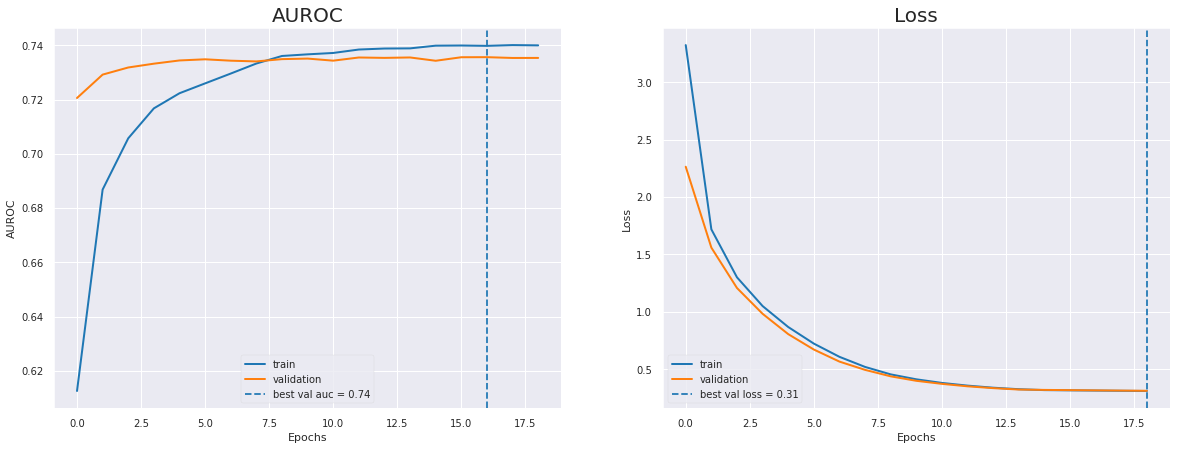

In [ ]:
# Plot training loss
plot_history(model)

COMMENT HERE

The AUROC score of training set rises as epoch increases and then flattens at the point when epoch is large enough. The AUROC score of the validation set starts high but flattens quickly after only a few of epochs. For this subsample of images, the best validation AUROC reaches 0.74, and the best validation loss reaches 0.31. There is no sign of model overfitting. However, there is mild sign of model over-regulation since the training loss is higher or the same than the validation loss for all epochs.

## 5.2 Performance Metrics

We generate predicted probabilities of class membership for all 14 diseases and the 'no finding' class on the test set. We then calculate the following metrics for each class:
1. Accuracy
2. Prevalence  
3. Sensitivity
4. Specificity
5. Positive Predictive Value      
6. Negative Predictive Value  
7. Area Under ROC 
8. AP Score  
9. F1 Score

Among these metrics, except Area Under ROC, AP Score, and F1 Score, all other metrics will depend on the choice of a threshold. Also, among these metrics, Accuracy, Prevalence, Positive Predictive Value, and Negative Predictive Value are not appropriate for evaluating class imbalance dataset, while Sensitivity, Specificity, Area Under ROC, AP Score, and F1 Score are the appropriate metrics for evaluating class imbalance dataset. Therefore, we focus more on the metrics of Area Under ROC, AP Score, and F1 Score, since they are not subject to the arbitrary choice of a threshold value and are the informative prediction metrics when significant class imbalance are present in the data.

In [ ]:
# Predict probability of class membership on the test set

pred = model.predict(test_ds_batches)
class_labels = test_selected_labels_df.drop(columns='image_filename').columns
pred_df = pd.DataFrame(pred, columns=class_labels)
pred_df.to_csv(base_path + 'output/pred.csv')
print(pred_df.head(100))

    Emphysema  No Finding  Pneumonia  Infiltration    Nodule     Edema  \
0    0.033975    0.205312   0.023358      0.272059  0.114738  0.035952   
1    0.034910    0.207376   0.024048      0.273489  0.116727  0.036878   
2    0.033465    0.204114   0.022938      0.270918  0.113835  0.035453   
3    0.033910    0.205109   0.023299      0.271674  0.114744  0.035827   
4    0.034327    0.205900   0.023634      0.272642  0.115534  0.036294   
..        ...         ...        ...           ...       ...       ...   
95   0.035675    0.208740   0.024742      0.274773  0.117997  0.037738   
96   0.034944    0.207513   0.024099      0.273865  0.116800  0.036919   
97   0.033875    0.204968   0.023263      0.272104  0.114605  0.035921   
98   0.034346    0.205952   0.023690      0.272633  0.115345  0.036335   
99   0.034689    0.205964   0.023966      0.273178  0.116356  0.036642   

    Consolidation  Atelectasis  Pneumothorax      Mass  Pleural_Thickening  \
0        0.068645     0.201705   

In [ ]:
# Get ground-truth class labels for the test set

correct_labels_df = test_selected_labels_df.drop(columns='image_filename')
print(correct_labels_df.head(100))

     Emphysema  No Finding  Pneumonia  Infiltration  Nodule  Edema  \
11           0           0          0             0       0      0   
4            0           0          0             0       0      0   
5            0           0          0             0       0      0   
6            0           0          0             1       0      0   
7            0           0          0             0       0      0   
..         ...         ...        ...           ...     ...    ...   
461          0           0          0             0       0      0   
463          0           0          0             0       0      0   
464          0           0          0             0       0      0   
465          0           0          0             0       0      0   
466          0           0          0             0       0      0   

     Consolidation  Atelectasis  Pneumothorax  Mass  Pleural_Thickening  \
11               0            0             0     0                   0   
4        

In [ ]:
# Function to calculate all performance metrics

def get_performance_metrics(y_df, pred_df, th, class_name):
  y = y_df[class_name].values
  pred = pred_df[class_name].values

  def true_positives(y, pred, th):
    TP = 0
    # get thresholded predictions
    thresholded_preds = pred >= th
    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    return TP

  def true_negatives(y, pred, th):
    TN = 0
    # get thresholded predictions
    thresholded_preds = pred >= th
    # compute TN
    TN = np.sum((y == 0) & (thresholded_preds == 0))
    return TN

  def false_positives(y, pred, th):
    FP = 0
    # get thresholded predictions
    thresholded_preds = pred >= th
    # compute FP
    FP = np.sum((y == 0) & (thresholded_preds == 1)) 
    return FP

  def false_negatives(y, pred, th):
    FN = 0
    # get thresholded predictions
    thresholded_preds = pred >= th    
    # compute FN
    FN = np.sum((y == 1) & (thresholded_preds == 0))  
    return FN

  def get_accuracy(y, pred, th):
    accuracy = 0.0
    # get TP, FP, TN, FN using our previously defined functions
    TP = true_positives(y, pred, th)
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th)
    FN = false_negatives(y, pred, th)
    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

  def get_prevalence(y):
    prevalence = 0.0
    prevalence = np.sum(y == 1) / len(y) 
    return prevalence

  def get_sensitivity(y, pred, th):
    sensitivity = 0.0
    # get TP and FN using our previously defined functions
    TP = true_positives(y, pred, th)
    FN = false_negatives(y, pred, th)
    # use TP and FN to compute sensitivity
    sensitivity = TP / (TP + FN)
    return sensitivity

  def get_specificity(y, pred, th):
    specificity = 0.0
    # get TN and FP using our previously defined functions
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th)
    # use TN and FP to compute specificity 
    specificity = TN / (TN + FP)
    return specificity

  def get_ppv(y, pred, th):
    PPV = 0.0
    # get TP and FP using our previously defined functions
    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)
    # use TP and FP to compute PPV
    PPV = TP / (TP + FP)
    return PPV

  def get_npv(y, pred, th):
    NPV = 0.0
    # get TN and FN using our previously defined functions
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)
    # use TN and FN to compute NPV
    NPV = TN / (TN + FN)
    return NPV

  def get_roc_auc(y, pred):
    return roc_auc_score(y, pred)

  def print_confidence_intervals(class_name, statistics):
    print("CI for disease {} roc_auc_score:".format(class_name))
    print(np.percentile(statistics, 2.5), np.percentile(statistics, 97.5))

  def bootstrap_auc(y, pred, class_name, bootstraps, fold_size):
    statistics = np.zeros((1, bootstraps))
    df = pd.DataFrame(columns=['y', 'pred'])
    df.loc[:, 'y'] = y_df[class_name]
    df.loc[:, 'pred'] = pred_df[class_name]
    # get positive examples for stratified sampling
    df_pos = df[df.y == 1]
    df_neg = df[df.y == 0]
    prevalence = len(df_pos) / len(df)
    for i in range(bootstraps):
      # stratified sampling of positive and negative examples
      pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
      neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

      y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
      pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
      score = roc_auc_score(y_sample, pred_sample)
      statistics[0][i] = score
    print_confidence_intervals(class_name, statistics)
    
  def get_ap_score(y, pred):
    return average_precision_score(y, pred)

  def get_f1(y, pred):
    precision = get_ppv(y, pred, th)
    recall = get_sensitivity(y, pred, th)
    F1 = 2 * (precision * recall) / (precision + recall)
    return F1

  accuracy = get_accuracy(y, pred, th)
  prevalence = get_prevalence(y)
  sensitivity = get_sensitivity(y, pred, th)
  specificity = get_specificity(y, pred, th)
  ppv = get_ppv(y, pred, th)
  npv = get_npv(y, pred, th)
  roc_auc = get_roc_auc(y, pred)
  #bootstrap_auc(y, pred, class_name, bootstraps = 100, fold_size = len(y)) # PROBLEM
  ap_score = get_ap_score(y, pred)   
  f1_score = get_f1(y, pred)

  return accuracy, prevalence, sensitivity, specificity, ppv, npv, roc_auc, ap_score, f1_score   

In [ ]:
# Iterate over class labels and calculate metrics

threshold = 0.5

metrics_dict = dict()
class_list = list()
accuracy_list = list()
prevalence_list = list() 
sensitivity_list = list() 
specificity_list = list() 
ppv_list = list() 
npv_list = list() 
roc_auc_list = list() 
ap_score_list = list() 
f1_score_list = list()

for class_label in class_labels:
  class_list.append(class_label)
  metrics_dict['class'] = class_list
  metrics_output = get_performance_metrics(y_df=correct_labels_df, pred_df=pred_df, th=threshold, class_name=class_label)
  accuracy, prevalence, sensitivity, specificity, ppv, npv, roc_auc, ap_score, f1_score = metrics_output
  accuracy_list.append(accuracy)
  metrics_dict['accuracy'] = accuracy_list
  prevalence_list.append(prevalence)
  metrics_dict['prevalence'] = prevalence_list
  sensitivity_list.append(sensitivity)
  metrics_dict['sensitivity'] = sensitivity_list
  specificity_list.append(specificity)
  metrics_dict['specificity'] = specificity_list
  ppv_list.append(ppv)
  metrics_dict['ppv'] = ppv_list
  npv_list.append(npv)
  metrics_dict['npv'] = npv_list
  roc_auc_list.append(roc_auc)
  metrics_dict['roc_auc'] = roc_auc_list
  ap_score_list.append(ap_score)
  metrics_dict['ap_score'] = ap_score_list
  f1_score_list.append(f1_score)
  metrics_dict['f1_score'] = f1_score_list

In [ ]:
# Summary metrics each class label on test set

metrics_df = pd.DataFrame.from_dict(metrics_dict)
print(metrics_df.round(2))

                 class  accuracy  prevalence  sensitivity  specificity  ppv  \
0            Emphysema      0.92        0.08          0.0          1.0  NaN   
1           No Finding      0.86        0.14          0.0          1.0  NaN   
2            Pneumonia      0.96        0.04          0.0          1.0  NaN   
3         Infiltration      0.71        0.29          0.0          1.0  NaN   
4               Nodule      0.89        0.11          0.0          1.0  NaN   
5                Edema      0.94        0.06          0.0          1.0  NaN   
6        Consolidation      0.87        0.13          0.0          1.0  NaN   
7          Atelectasis      0.81        0.19          0.0          1.0  NaN   
8         Pneumothorax      0.84        0.16          0.0          1.0  NaN   
9                 Mass      0.88        0.12          0.0          1.0  NaN   
10  Pleural_Thickening      0.92        0.08          0.0          1.0  NaN   
11            Effusion      0.75        0.25        

COMMENT HERE

We focus on AUROC and AP metrics since F1 scores are unavailable. From ap_score for each class, we see that ap_score is larger for the class with larger prevalence. The model predicts best for the "Infiltration" class whose prevalence is the highest, and predicts worst for the "Hernia" class whose prevalence is the lowest. AUROC does not depend on prevalence. We have AUROC scores in a range from 0.48 for class "Pneumonia"/"Hernia" to 0.52 for class "Fibrosis".

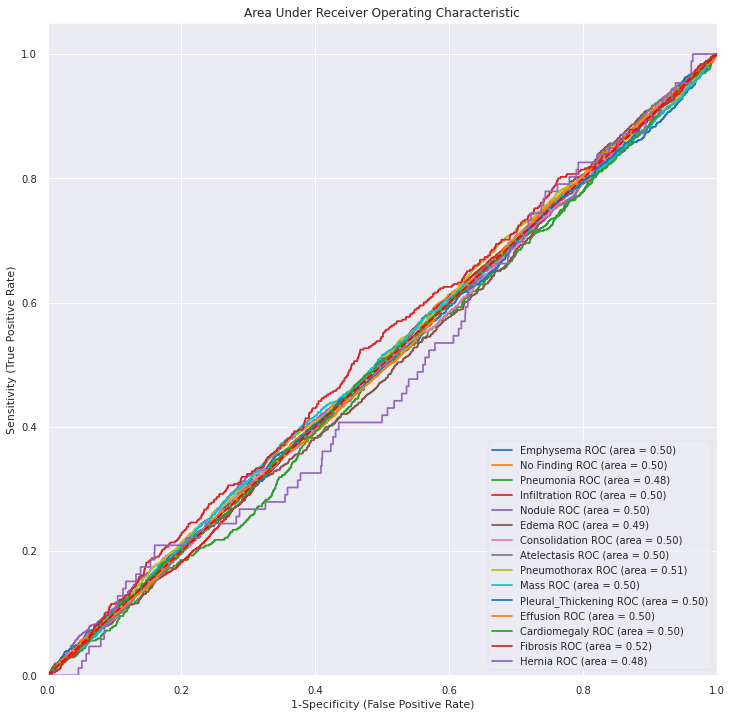

In [ ]:
# AUROC for all classes

plt.figure(figsize=(12, 12))

for class_label in class_labels:
  y = correct_labels_df[class_label].values
  pred = pred_df[class_label].values
  fpr, tpr, thresholds = roc_curve(y, pred)
  auc = roc_auc_score(y, pred)
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (class_label, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Area Under Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show() 

COMMENT HERE

The model does not have strong predictive power. The model predicts well for some of the rare classes. For example, the AUROC for "Fibrosis" reaches 0.52-the highest AUROC-when the disease's prevalence is only 0.03.

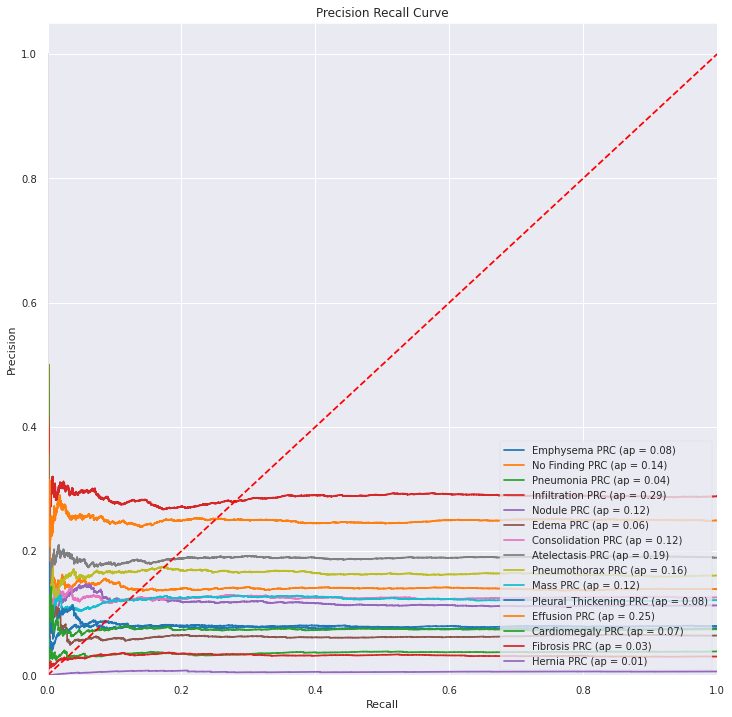

In [ ]:
# Precision Recall Curve for all classes

plt.figure(figsize=(12, 12))

for class_label in class_labels:
  y = correct_labels_df[class_label].values
  pred = pred_df[class_label].values
  p, r, t = precision_recall_curve(y, pred)
  ap_score = average_precision_score(y, pred)
  plt.plot(r, p, label='%s PRC (ap = %0.2f)' % (class_label, ap_score))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower right")
plt.show()  

COMMENT HERE

The model predicts best for the "Infiltration" class whose prevalence is the highest, and predicts worst for the "Hernia" class whose prevalence is the lowest.

<a name="6.-Layer-Visualizations"></a>
# 6. Layer Visualizations

[Return to top](#Notebook-Contents)

In [ ]:
# Add code for layer activation visualizations here


<a name="7.-Conclusions"></a>
# 7. Conclusions

[Return to top](#Notebook-Contents)

<a name="8.-Future-Work"></a>
# 8. Future Work

[Return to top](#Notebook-Contents)

In our analysis of the Chest X-ray dataset we have tried a variety of modeling and feature engineering approaches, but there are still many additional steps that could be taken:

1. **Incorporating non-image data into the model.** Non-image data (e.g., sex, age, patient ID) may also be predictive of disease class. Future work could explore model architectures that can incorporate both image and non-image data by building custom model layers.

2. **Additional data augmentation approaches.** Artificially coloring the images. 


<a name="9.-References"></a>
# 9. References

[Return to top](#Notebook-Contents)

**The following are links to papers, blogs, and tutorials we found useful during the development of this project:**

Fine-tuning for transfer learning models:
https://keras.io/guides/transfer_learning/

Medical neural networks:
https://glassboxmedicine.com/

Image classification using CNNs:
https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a

Comparison of ResNet50 and VGG19 and training from stratch for X-ray images dataset:
https://www.sciencedirect.com/science/article/pii/S2666285X21000558

Tensorflow Applications for base model:
https://keras.io/api/applications/

Tensorboard confusion matrix:
https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12

Pre-processing and modeling pipelines (ResNet50):
https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435

Image data input pipelines:
https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5

Split TF datasets:
https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

Transfer learning with EfficientNet:
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Training greyscale images using transfer learning:
https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images

Multi-label vs multi-class classification:
https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/

Multi-label classification example use-case:
https://towardsdatascience.com/fast-ai-season-1-episode-3-a-case-of-multi-label-classification-a4a90672a889

Element-wise sigmoid:
https://www.programcreek.com/python/example/93769/keras.backend.sigmoid

Element-wise sigmoid:
https://stackoverflow.com/questions/52090857/how-to-apply-sigmoid-function-for-each-outputs-in-keras

DenseNet121:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8189817/